# Transformer for time series forecast

The present notebooks presents an application of a transformer for time series forecasting by adapting the model's architechtures.

In [30]:
import os
import sys

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

src_path = os.path.dirname(os.getcwd())
sys.path.append(src_path)

from Transformers.data_processing import window_dataset_sequence_to_sequence
from Transformers.model import Transformer

## Data: Drivers killed

The data corresponds to a time series giving the monthly total of car drivers in Great Britain killed or seriously injured betwen Jan 1969 to Dec 1984. Compulsory wearing of seat belts was introducedon 31 Jan 1983

In [4]:
raw_data = pd.read_csv(os.path.join(src_path, "data", "road_casualties.csv"))
raw_data.head()

,Unnamed: 0,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,1,107,1687,867,269,9059,0.102972,12,0
1,2,97,1508,825,265,7685,0.102363,6,0
2,3,102,1507,806,319,9963,0.102062,12,0
3,4,87,1385,814,407,10955,0.100873,8,0
4,5,119,1632,991,454,11823,0.101020,10,0


In [5]:
data = raw_data.drop(columns=["Unnamed: 0"])
years = range(1969, 1985)
months = range(1,13)
pairs = [[year, month] for year in years for month in months]
data = pd.concat([data, pd.DataFrame(pairs)], axis = 1)
data.columns = [
    "deaths",
    "drivers",
    "front",
    "rear",
    "kms", 
    "petrol_price",
    "van_killed",
    "law",
    "year",
    "month"
]
data.head()

,deaths,drivers,front,rear,kms,petrol_price,van_killed,law,year,month
0,107,1687,867,269,9059,0.102972,12,0,1969,1
1,97,1508,825,265,7685,0.102363,6,0,1969,2
2,102,1507,806,319,9963,0.102062,12,0,1969,3
3,87,1385,814,407,10955,0.100873,8,0,1969,4
4,119,1632,991,454,11823,0.101020,10,0,1969,5


In [6]:
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(data)
response_scaler = MinMaxScaler()
response_scaler.fit(data['deaths'].values.reshape(-1,1))

MinMaxScaler()

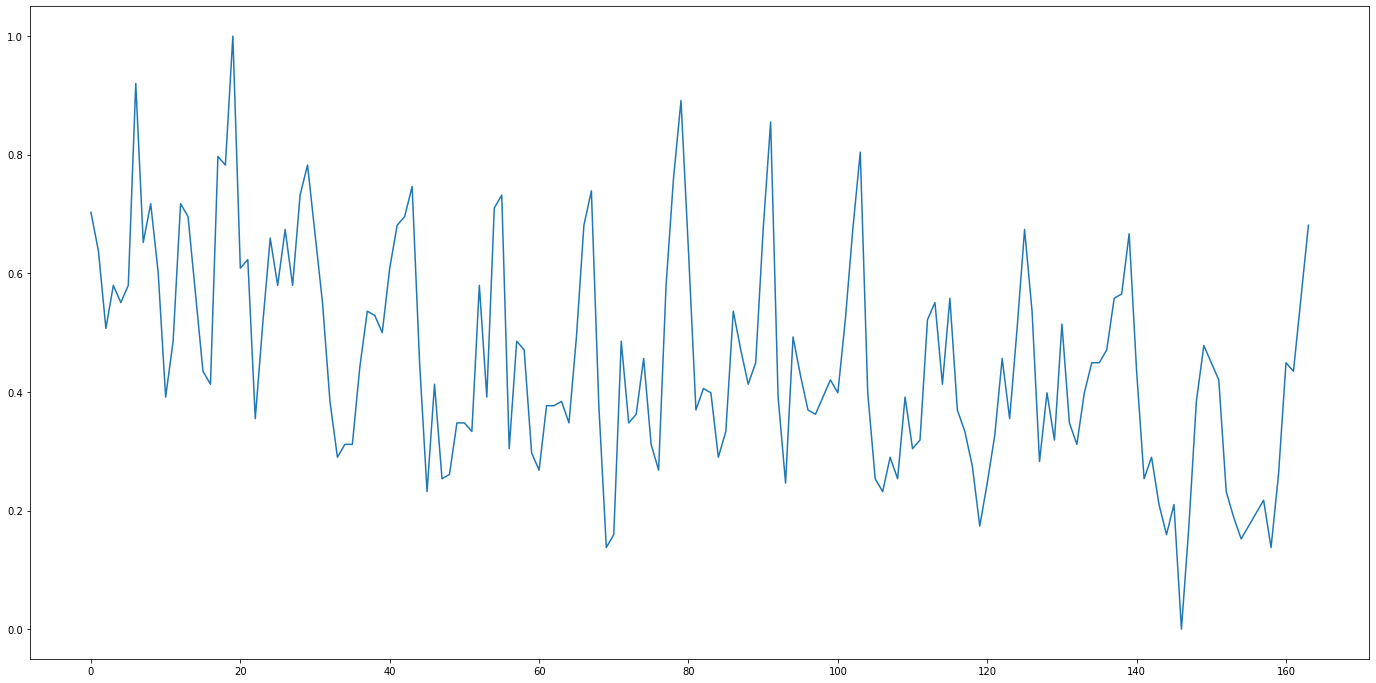

In [7]:
val_size = int(0.15*scaled_data.shape[0])
train_data, val_data = scaled_data[val_size:], scaled_data[:val_size] 
plt.figure(figsize=(24,12))
plt.plot(train_data[:,0])
plt.show()

In [8]:
train_ds = window_dataset_sequence_to_sequence(
    data=train_data,
    sequence_lenght=12,
    output_lenght=1,
    batch_size=1,
    shift=1,
    shuffle=True    
)
val_ds = window_dataset_sequence_to_sequence(
    data=val_data,
    sequence_lenght=12,
    output_lenght=1,
    batch_size=1,
    shift=1,
    shuffle=False  
)

predict_ds = window_dataset_sequence_to_sequence(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=1,
    batch_size=180,
    shift=1, 
    shuffle=False
)

In [9]:
num_layers = 4
d_model = 10
dff = 32
num_heads = 6
d_target = 10
dropout_rate = 0.1
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    d_target = d_target,
    dropout_rate = dropout_rate,
    input_lenght=12,
    output_lenght=12
)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transformer.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=optimizer,
    metrics=["mape"]
)

transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200
)

Epoch 1/200
152/152 [==============================] - 21s 59ms/step - loss: 0.2218 - mape: 47589388.0000 - val_loss: 0.0575 - val_mape: 13995068.0000
Epoch 2/200
152/152 [==============================] - 6s 40ms/step - loss: 0.0570 - mape: 18603272.0000 - val_loss: 0.0743 - val_mape: 13046440.0000
Epoch 3/200
152/152 [==============================] - 6s 41ms/step - loss: 0.0497 - mape: 17277550.0000 - val_loss: 0.0589 - val_mape: 16848134.0000
Epoch 4/200
152/152 [==============================] - 6s 43ms/step - loss: 0.0413 - mape: 15347774.0000 - val_loss: 0.0446 - val_mape: 21057750.0000
Epoch 5/200
152/152 [==============================] - 6s 41ms/step - loss: 0.0382 - mape: 15402462.0000 - val_loss: 0.0464 - val_mape: 21434602.0000
Epoch 6/200
152/152 [==============================] - 6s 42ms/step - loss: 0.0349 - mape: 15755155.0000 - val_loss: 0.0432 - val_mape: 19707578.0000
Epoch 7/200
152/152 [==============================] - 6s 38ms/step - loss: 0.0317 - mape: 13662479

1/1 [==============================] - 0s 126ms/step


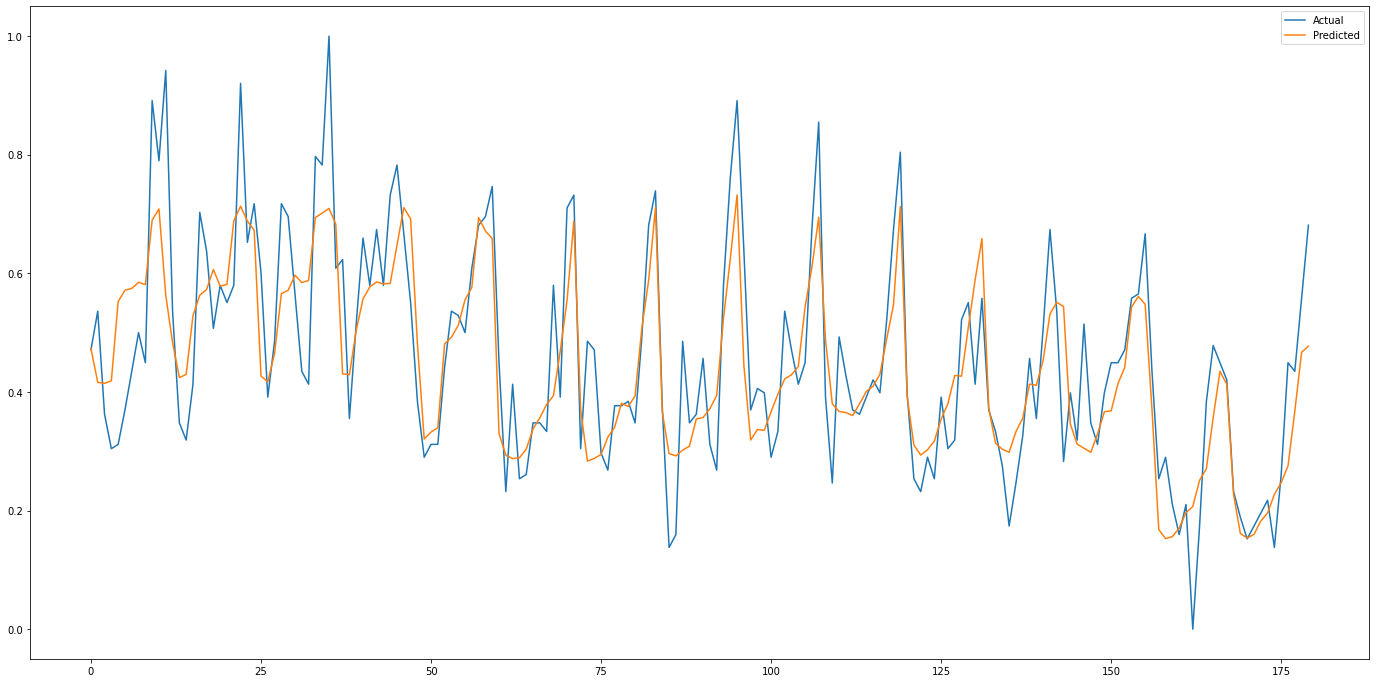

In [15]:
predictions = transformer.predict(predict_ds)
preds = predictions[:,0,0]
plt.figure(figsize=(24,12))
plt.plot(scaled_data[12:, 0])
plt.plot(preds.reshape(-1))
plt.legend(["Actual", "Predicted"])
plt.show()

In [23]:
orig_preds = minmax_scaler.inverse_transform(predictions.reshape((180,10)))

In [26]:
orig_preds[:,0]

array([125.319595, 117.426765, 117.20555 , 117.7932  , 136.22128 ,
       138.87721 , 139.28806 , 140.7098  , 140.17877 , 155.19647 ,
       157.78752 , 137.71617 , 126.69818 , 118.55082 , 119.27935 ,
       132.98384 , 137.72124 , 139.03204 , 143.68892 , 139.80641 ,
       140.23047 , 155.00441 , 158.43161 , 154.96559 , 152.82848 ,
       118.89465 , 117.54529 , 124.19785 , 138.0766  , 138.87148 ,
       142.37242 , 140.64586 , 141.14981 , 155.78014 , 156.81068 ,
       157.91287 , 154.23154 , 119.41149 , 119.21193 , 129.5061  ,
       136.82814 , 139.64113 , 140.79457 , 140.34947 , 140.45963 ,
       149.39998 , 158.0913  , 155.50172 , 126.4356  , 104.239426,
       105.871284, 106.88265 , 126.40869 , 127.920135, 130.69057 ,
       136.64601 , 139.53499 , 155.77925 , 152.64523 , 150.90643 ,
       105.50803 , 100.47454 ,  99.68518 ,  99.88418 , 101.895454,
       106.563995, 109.1928  , 112.295235, 114.34069 , 124.679276,
       136.49432 , 154.97595 , 111.11472 ,  99.10287 ,  99.724

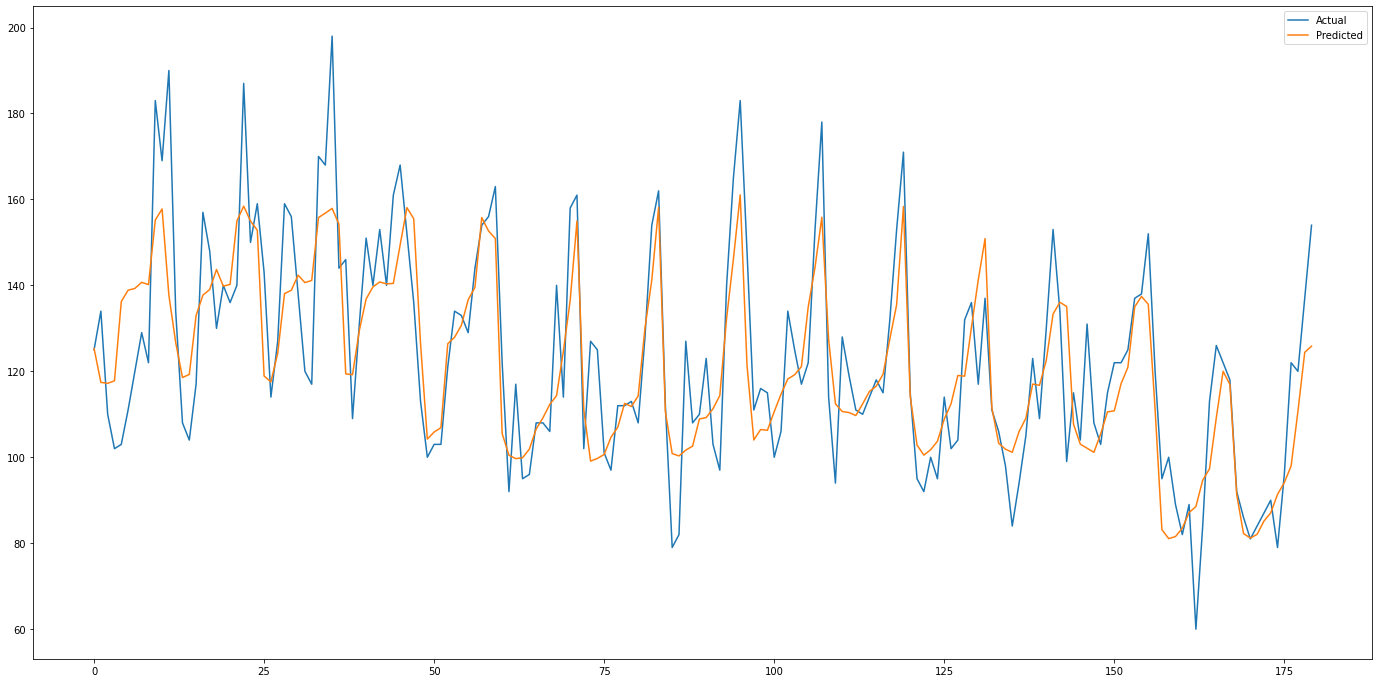

In [27]:
plt.figure(figsize=(24,12))
plt.plot(data.to_numpy()[12:, 0])
plt.plot(orig_preds[:,0])
plt.legend(["Actual", "Predicted"])
plt.show()

In [28]:
mean_squared_error(data.to_numpy()[12:, 0], orig_preds[:, 0])

200.7583252627726

In [29]:
residuals = data.to_numpy()[12:, 0] - orig_preds[:, 0]

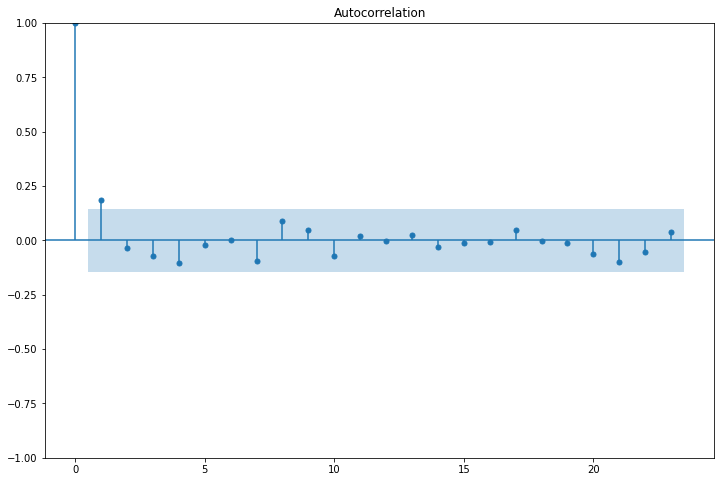

In [31]:
plt.rc("figure", figsize=(12,8))
plot_acf(residuals, bartlett_confint=False)
plt.show()

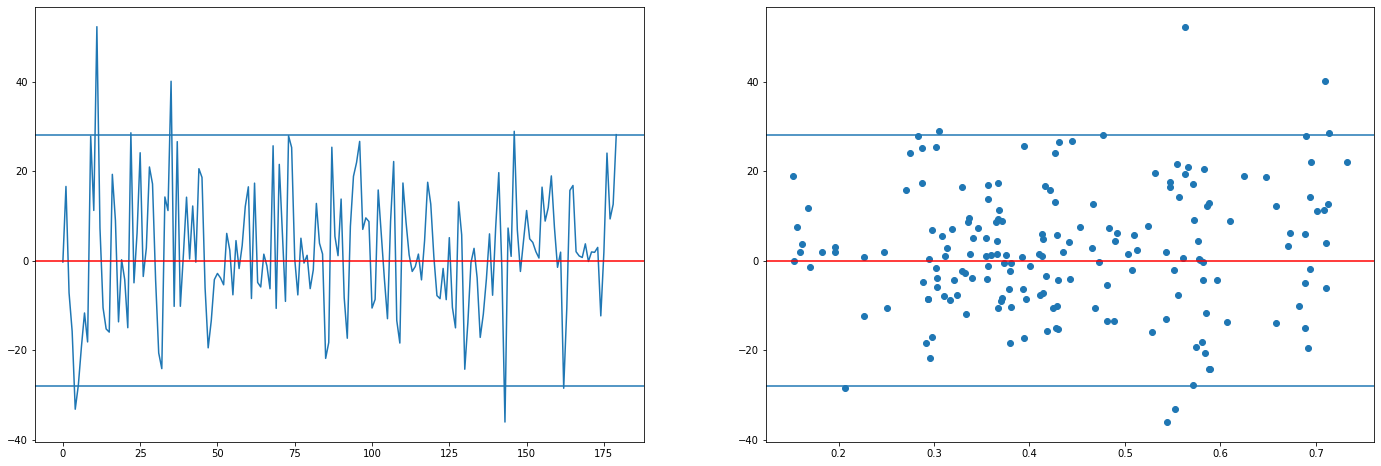

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))

ax1.plot(residuals)
ax1.axhline(0, color='r')
ax1.axhline(2*np.std(residuals))
ax1.axhline(-2*np.std(residuals))

ax2.plot(preds, residuals, 'o')
ax2.axhline(0, color='r')
ax2.axhline(2*np.std(residuals))
ax2.axhline(-2*np.std(residuals))

plt.show()